In [39]:
#from sirf.Gadgetron import AcquisitionData, CoilSensitivityData, AcquisitionModel, ImageData
import numpy as np
import sys
#sys.path.append("/home/jovyan/P1-Temp-Reg/modelbased-approach/")
import numpybased_auxiliary as aux
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
from multiprocessing import Process, Pipe

In [40]:
DIR = "/Users/fatimaantarouba/Desktop/Studium/Mathematik/Doktor/Programs/Git-Repo/Hackaton/Output"
dat = np.load("{}/data_as_matrices.npz".format(DIR))

y = dat["y"]
mask = dat["mask"]

A = aux.A(mask)
u = np.zeros(y.shape, dtype=y.dtype)

In [78]:
class LHS():
    def __init__(self, template_shape, beta_x, beta_t,A,Dx,Dt):
        self.template_shape = template_shape
        self.beta_x = beta_x
        self.beta_t = beta_t
        self.A = A
        self.Dx = Dx
        self.Dt = Dt
    
    def forward(self,u):
        b = np.reshape(u,self.template_shape)
        return self.Left_hand_side(b)
        
    def Left_hand_side(self, u):

        first_part = self.A.backward(self.A.forward(u))
        second_part = self.beta_t*self.Dt.backward(self.Dt.forward(u))
        third_part = self.beta_x * self.Dx.backward(self.Dx.forward(u))
        return (first_part + second_part + third_part+0.02*u).flatten()

    def backward(self, u):
        b = np.reshape(u,self.template_shape)
        return self.back_Left_hand_side(b)
    
    def back_Left_hand_side(self, u):

        first_part = self.A.forward(self.A.backward(u))
        second_part = self.beta_t*self.Dt.forward(self.Dt.backward(u))
        third_part = self.beta_x * self.Dx.forward(self.Dx.backward(u))
        return (first_part + second_part + third_part+0.02*u).flatten()



In [79]:
def Right_hand_side(y,mu_x, mu_t, z_x, z_t, beta_x,beta_t, A,Dx,Dt):
    return (A.backward(y) - Dx.backward(mu_x)- Dt.backward(mu_t)
            + beta_t*Dt.backward(z_t) + beta_x*Dx.backward(z_x))
        

In [80]:
def compute_init_u(y,A):
    return A.backward(y)

In [81]:
def solve_u_step(u_k,zt_k,zx_k,beta_x,beta_t,mut_k,mux_k, y,A,Dx,Dt):
    lhs = LHS(u_k.shape, beta_x, beta_t,A,Dx,Dt)
    operator_shape= (u_k.size, u_k.size)
    RHS = Right_hand_side(y,mux_k, mut_k, zx_k, zt_k,beta_x,beta_t, A,Dx,Dt)
    Operator = LinearOperator(operator_shape, matvec=lhs.forward )
    
    #u_next = bicgstab(Operator, RHS.flatten(), u_k.flatten())
    u_next=conjgrad(Operator, RHS.flatten(), u_k.flatten())
    return u_next[0].reshape(u_k.shape)

def solve_z_step(u_k, beta_t, beta_x, mut_k, mux_k, alpha, beta, A, Dx, Dt):  
    
    tmp = Dx.forward(u_k)
    tmp = (mux_k[0]/beta_x - tmp[0], mux_k[1]/beta_x - tmp[1])
        
    zkx_0 = prox_complexed_valued_image(beta/beta_x, tmp[0])
    zkx_1 = prox_complexed_valued_image(beta/beta_x, tmp[1])
    #zkx_0 = prox(beta/beta_x, tmp[0])
    #zkx_1 = prox(beta/beta_x, tmp[1])
    zkx = (zkx_0, zkx_1)
    
    tmp = mut_k/beta_t - Dt.forward(u_k)
    zkt = prox_complexed_valued_image(alpha/beta_t, tmp)
    #zkt = prox(alpha/beta_t, tmp)
    return zkx, zkt
    
def prox(alpha,x):
    prox_output = x
    prox_output = np.sign(x)*np.max(np.abs(x) -  alpha,0)
    return prox_output

def prox_complexed_valued_image(alpha, x):
    phi = lambda x, gamma: np.max(1-(gamma/x), 0)
    return x*phi(norm_cv(x), 1/alpha)
    
def norm_cv(x):
    return np.sqrt(np.sum(x.real**2 + x.imag**2))

def conjgrad(A, b, x):
    r = b - A(x)
    p = r;
    rsold = np.sum(r*r)
    k=0
    while i<10:
        Ap = A(p)
        alpha = rsold / np.sum(p*Ap)
        x = x + np.sum(alpha*p)
        #r = r - np.sum(alpha*Ap)
        rsnew = np.sum(r*r)
        print(k, norm_cv(rsnew))
        if np.sqrt(rsnew) < 1e-4:
             return x
        p = r + np.dot(rsnew / rsold, p)
        rsold = rsnew
        k +=1
    return x

In [120]:
from tqdm import tqdm
#from norms import l2_diff
#from iter_module import p_exact_2d, rhs_2d
u_k = compute_init_u(y,A)
#n_x, n_y, n_t = u_k.shape
#d_x = lx/(n_x-1)
#d_y = ly/(n_y-1)
#d_t = lt/(n_t-1)

Dx = aux.Dx()
Dt = aux.Dt()
zt_k = Dt.forward(u_k)
zx_k = Dx.forward(u_k)
beta_x = 0.1
beta_t = 0.1
zt_k[:] = 0
zx_k[0][:] = 0
zx_k[1][:] = 0

mut_k = zt_k
mut_k[:] = 0
mux_k = (mut_k, mut_k)


#https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/05_IterativeMethods/05_02_Conjugate_Gradient.html
def conj_g(u_k,zt_k,zx_k,beta_t,beta_x,mut_k,mux_k, y,A,Dx,Dt):
   
    b=Right_hand_side(y,mux_k, mut_k, zx_k, zt_k,beta_x,beta_t, A,Dx,Dt).flatten()
    lhs = LHS(u_k.shape, beta_x, beta_t,A,Dx,Dt)

    # Initial guess
    p0 = np.zeros(b.shape, dtype=np.complex_)#, dtype=np.complex_)

    # Place holders for the residual r and A(d)
    r = np.zeros(b.shape, dtype=np.complex_)#, dtype=np.complex_)
    Ad = np.zeros(b.shape, dtype=np.complex_)#, dtype=np.complex_)

    tolerance = 1e-10
    max_it = 500


    pbar = tqdm(total=max_it)
    pbar.set_description("iter / max_it");

    it = 0 # iteration counter
    diff = 1.0
    tol_hist_jac = []

    p = p0.copy()

    # Initial residual r0 and initial search direction d0
    r = -b - lhs.forward(p)
    d = r.copy()

    while (diff > tolerance):
        if it > max_it:
            print('\nSolution did not converged within the maximum'
                  ' number of iterations'
                  f'\nLast l2_diff was: {diff:.5e}')
            break

        # Laplacian of the search direction.
        Ad = lhs.forward(d)
        # Magnitude of jump.
        alpha = np.sum(np.conj(r)*r) / np.sum(np.conj(d)*Ad)
        # Iterated solution
        pnew = p + alpha*d
        # Intermediate computation
        beta_denom = np.sum(np.conj(r)*r)
        # Update the residual.
        r = r - alpha*Ad
        # Compute beta
        beta = np.sum(r*r) / beta_denom
        # Update the search direction.
        d = r + beta*d

        diff =norm_cv(r) #l2_diff(pnew, p)
        #print(diff)
        tol_hist_jac.append(diff)

        # Get ready for next iteration
        it += 1
        np.copyto(p, pnew)
        # We update our progress bar
        pbar.update(1)

    else:
        print(f'\nThe solution converged after {it} iterations')

    # When the progress bar will not be used
    # further, it has to be closed
    del(pbar)
    return p.reshape(u_k.shape)
p = conj_g(u_k,zt_k,zx_k,beta_t,beta_x,mut_k,mux_k, y,A,Dx,Dt)
#p_imag = conj_g(u_k.imag)
#p=p_real+ p_imag*1j

iter / max_it: : 501it [00:06, 79.26it/s]                                       


Solution did not converged within the maximum number of iterations
Last l2_diff was: 6.32285e-01


In [121]:
beta_1 = 0.1
beta_2 = 0.1

import time
tstart = time.time()
#result = solve_u_step(u_k,zt_k,zx_k,beta_1,beta_2,mut_k,mux_k, y,A,Dx,Dt)
result=p
#print(time.time()-tstart)

iter / max_it: : 501it [00:06, 76.22it/s]


Text(0.5, 1.0, 'end')

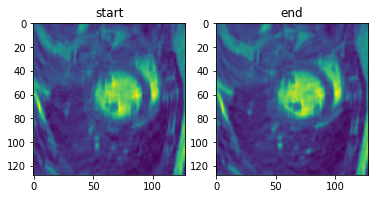

In [122]:
resimg = np.reshape(result, (128,128,12))
import matplotlib.pyplot as plt

plotframe = 6
f,ax = plt.subplots(1,2)
ax[0].imshow(np.abs(np.squeeze(u_k[:,:,plotframe])))
ax[0].set_title('start')
ax[1].imshow(np.abs(np.squeeze(resimg[:,:,plotframe])))
ax[1].set_title('end')


In [123]:
from tqdm import tqdm
def alternative_lagrange_multiplier(max_iter):
    A = aux.A(mask)
    
    u_k = compute_init_u(y,A)
    Dx = aux.Dx()
    Dt = aux.Dt()
    zt_k = Dt.forward(u_k)
    zx_k = Dx.forward(u_k)

    zt_k[:] = 0
    zx_k[0][:] = 0
    zx_k[1][:] = 0

    mut_k = zt_k
    mut_k[:] = 0
    mux_k = (mut_k, mut_k)
    mut_k = zt_k.copy()
    mut_k.fill(1.0)
    
    alpha = 0.2*np.ones(u_k.shape)
    beta = 0.2*np.ones(u_k.shape)
    
    beta_t = 0.1 #2.0
    beta_x = 0.1
    
    for i in tqdm(range(max_iter)):
        time_start = time.time()
        u_k = conj_g(u_k,zt_k,zx_k,beta_t,beta_x,mut_k,mux_k, y,A,Dx,Dt)
        #solve_u_step(u_k,zt_k,zx_k,beta_t,beta_x,mut_k,mux_k, y,A,Dx,Dt)
        
        print(time.time()- time_start)
        
        zk_x, zk_t = solve_z_step(u_k, beta_t, beta_x, mut_k, mux_k, alpha, beta, A, Dx, Dt)
        
        mut_k += Dt.forward(u_k)-zt_k
        mux_k = (mux_k[0] + Dx.forward(u_k)[0]-zx_k[0], mux_k[1] + Dx.forward(u_k)[1]-zx_k[1])
    
    return u_k

In [124]:
maxiter=  10
result = alternative_lagrange_multiplier(maxiter)
print(result)

 10%|████▍                                       | 1/10 [00:07<01:04,  7.19s/it]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

iter / max_it:   0%|                                    | 0/500 [00:00<?, ?it/s]

iter / max_it:   1%|▎                           | 6/500 [00:00<00:08, 57.48it/s]


Solution did not converged within the maximum number of iterations
Last l2_diff was: 6.32285e-01
7.180273056030273




iter / max_it:   3%|▋                          | 13/500 [00:00<00:07, 62.21it/s]

iter / max_it:   4%|█                          | 20/500 [00:00<00:07, 64.98it/s]

iter / max_it:   5%|█▍                         | 27/500 [00:00<00:07, 65.95it/s]

iter / max_it:   7%|█▊                         | 34/500 [00:00<00:07, 65.57it/s]

iter / max_it:   8%|██▏                        | 41/500 [00:00<00:07, 65.50it/s]

iter / max_it:  10%|██▋                        | 49/500 [00:00<00:06, 66.92it/s]

iter / max_it:  11%|███                        | 57/500 [00:00<00:06, 68.75it/s]

iter / max_it:  13%|███▌                       | 66/500 [00:00<00:05, 72.80it/s]

iter / max_it:  15%|███▉                       | 74/500 [00:01<00:05, 71.32it/s]

iter / max_it:  17%|████▍                      | 83/500 [00:01<00:05, 74.69it/s]

iter / max_it:  18%|████▉                      | 91/500 [00:01<00:05, 73.70it/s]

iter / max_it:  20%|█████▎                     | 99/500 [00:01<00:05, 69.66it/s]

iter / max_it:


Solution did not converged within the maximum number of iterations
Last l2_diff was: 7.18892e+00
7.030345916748047





iter / max_it:   3%|▊                          | 14/500 [00:00<00:07, 63.06it/s]


iter / max_it:   4%|█▏                         | 21/500 [00:00<00:07, 65.07it/s]


iter / max_it:   6%|█▌                         | 29/500 [00:00<00:06, 68.95it/s]


iter / max_it:   8%|██                         | 38/500 [00:00<00:06, 74.06it/s]


iter / max_it:   9%|██▌                        | 47/500 [00:00<00:05, 77.91it/s]


iter / max_it:  11%|██▉                        | 55/500 [00:00<00:05, 77.04it/s]


iter / max_it:  13%|███▍                       | 63/500 [00:00<00:05, 77.70it/s]


iter / max_it:  14%|███▊                       | 71/500 [00:00<00:05, 76.20it/s]


iter / max_it:  16%|████▎                      | 80/500 [00:01<00:05, 79.15it/s]


iter / max_it:  18%|████▊                      | 88/500 [00:01<00:05, 76.07it/s]


iter / max_it:  19%|█████▏                     | 97/500 [00:01<00:05, 78.12it/s]


iter / max_it:  21%|█████▍                    | 105/500 [00:01<00:05, 77.83it/s]


i


Solution did not converged within the maximum number of iterations
Last l2_diff was: 8.94761e+01
6.911634922027588






iter / max_it:   3%|▋                          | 13/500 [00:00<00:07, 63.09it/s]



iter / max_it:   4%|█                          | 20/500 [00:00<00:07, 65.51it/s]



iter / max_it:   5%|█▍                         | 27/500 [00:00<00:07, 67.20it/s]



iter / max_it:   7%|█▉                         | 35/500 [00:00<00:06, 68.82it/s]



iter / max_it:   9%|██▎                        | 43/500 [00:00<00:06, 69.63it/s]



iter / max_it:  10%|██▊                        | 51/500 [00:00<00:06, 70.47it/s]



iter / max_it:  12%|███▏                       | 59/500 [00:00<00:06, 70.96it/s]



iter / max_it:  13%|███▌                       | 67/500 [00:00<00:06, 70.81it/s]



iter / max_it:  15%|████                       | 75/500 [00:01<00:06, 69.75it/s]



iter / max_it:  16%|████▍                      | 82/500 [00:01<00:06, 69.65it/s]



iter / max_it:  18%|████▊                      | 90/500 [00:01<00:05, 70.93it/s]



iter / max_it:  20%|█████▎                     | 98/500 [00:01<00:05, 70


Solution did not converged within the maximum number of iterations
Last l2_diff was: 1.42322e+03
6.664829969406128







iter / max_it:   3%|▊                          | 16/500 [00:00<00:06, 76.93it/s]




iter / max_it:   5%|█▎                         | 24/500 [00:00<00:06, 75.80it/s]




iter / max_it:   7%|█▊                         | 33/500 [00:00<00:05, 79.38it/s]




iter / max_it:   8%|██▎                        | 42/500 [00:00<00:05, 81.36it/s]




iter / max_it:  10%|██▊                        | 51/500 [00:00<00:05, 82.43it/s]




iter / max_it:  12%|███▏                       | 60/500 [00:00<00:05, 83.77it/s]




iter / max_it:  14%|███▋                       | 69/500 [00:00<00:05, 84.58it/s]




iter / max_it:  16%|████▏                      | 78/500 [00:00<00:04, 84.87it/s]




iter / max_it:  17%|████▋                      | 87/500 [00:01<00:04, 84.70it/s]




iter / max_it:  19%|█████▏                     | 96/500 [00:01<00:04, 82.48it/s]




iter / max_it:  21%|█████▍                    | 105/500 [00:01<00:04, 83.21it/s]




iter / max_it:  23%|█████▉                    | 114/500 [00:


Solution did not converged within the maximum number of iterations
Last l2_diff was: 1.87961e+04
6.149998903274536








iter / max_it:   3%|▊                          | 14/500 [00:00<00:07, 66.02it/s]





iter / max_it:   4%|█▏                         | 21/500 [00:00<00:07, 66.94it/s]





iter / max_it:   6%|█▌                         | 28/500 [00:00<00:06, 67.76it/s]





iter / max_it:   7%|█▉                         | 35/500 [00:00<00:06, 67.10it/s]





iter / max_it:   9%|██▎                        | 43/500 [00:00<00:06, 69.12it/s]





iter / max_it:  10%|██▊                        | 51/500 [00:00<00:06, 71.02it/s]





iter / max_it:  12%|███▏                       | 59/500 [00:00<00:06, 71.66it/s]





iter / max_it:  13%|███▌                       | 67/500 [00:00<00:06, 71.03it/s]





iter / max_it:  15%|████                       | 75/500 [00:01<00:05, 72.14it/s]





iter / max_it:  17%|████▍                      | 83/500 [00:01<00:05, 72.02it/s]





iter / max_it:  18%|████▉                      | 91/500 [00:01<00:05, 69.91it/s]





iter / max_it:  20%|█████▎                     |


Solution did not converged within the maximum number of iterations
Last l2_diff was: 4.82445e+05
7.055920124053955









iter / max_it:   3%|▊                          | 15/500 [00:00<00:07, 67.62it/s]






iter / max_it:   4%|█▏                         | 22/500 [00:00<00:07, 67.19it/s]






iter / max_it:   6%|█▌                         | 30/500 [00:00<00:06, 71.59it/s]






iter / max_it:   8%|██                         | 39/500 [00:00<00:06, 76.10it/s]






iter / max_it:   9%|██▌                        | 47/500 [00:00<00:06, 72.53it/s]






iter / max_it:  11%|██▉                        | 55/500 [00:00<00:06, 72.18it/s]






iter / max_it:  13%|███▍                       | 63/500 [00:00<00:06, 72.31it/s]






iter / max_it:  14%|███▊                       | 71/500 [00:00<00:06, 71.10it/s]






iter / max_it:  16%|████▎                      | 79/500 [00:01<00:05, 73.47it/s]






iter / max_it:  18%|████▊                      | 88/500 [00:01<00:05, 76.97it/s]






iter / max_it:  19%|█████▏                     | 97/500 [00:01<00:05, 78.13it/s]






iter / max_it:  21%|█████▍          


Solution did not converged within the maximum number of iterations
Last l2_diff was: 7.72206e+06
6.629306316375732










iter / max_it:   3%|▊                          | 14/500 [00:00<00:07, 64.70it/s]







iter / max_it:   4%|█▏                         | 22/500 [00:00<00:06, 69.03it/s]







iter / max_it:   6%|█▋                         | 31/500 [00:00<00:06, 76.02it/s]







iter / max_it:   8%|██                         | 39/500 [00:00<00:06, 75.51it/s]







iter / max_it:  10%|██▌                        | 48/500 [00:00<00:05, 78.01it/s]







iter / max_it:  11%|███                        | 57/500 [00:00<00:05, 80.14it/s]







iter / max_it:  13%|███▌                       | 66/500 [00:00<00:05, 78.65it/s]







iter / max_it:  15%|███▉                       | 74/500 [00:00<00:05, 78.12it/s]







iter / max_it:  17%|████▍                      | 83/500 [00:01<00:05, 80.21it/s]







iter / max_it:  18%|████▉                      | 92/500 [00:01<00:05, 80.93it/s]







iter / max_it:  20%|█████▎                    | 101/500 [00:01<00:05, 77.48it/s]







iter / max_it:  22%|████


Solution did not converged within the maximum number of iterations
Last l2_diff was: 8.94248e+07
6.811324119567871











iter / max_it:   3%|▊                          | 15/500 [00:00<00:06, 73.04it/s]








iter / max_it:   5%|█▎                         | 24/500 [00:00<00:06, 77.56it/s]








iter / max_it:   7%|█▊                         | 33/500 [00:00<00:05, 79.73it/s]








iter / max_it:   8%|██▎                        | 42/500 [00:00<00:05, 81.31it/s]








iter / max_it:  10%|██▊                        | 51/500 [00:00<00:05, 81.55it/s]








iter / max_it:  12%|███▏                       | 60/500 [00:00<00:05, 81.79it/s]








iter / max_it:  14%|███▋                       | 69/500 [00:00<00:05, 81.87it/s]








iter / max_it:  16%|████▏                      | 78/500 [00:00<00:05, 82.04it/s]








iter / max_it:  17%|████▋                      | 87/500 [00:01<00:05, 79.60it/s]








iter / max_it:  19%|█████▏                     | 96/500 [00:01<00:04, 81.16it/s]








iter / max_it:  21%|█████▍                    | 105/500 [00:01<00:04, 82.07it/s]








iter / max_i


Solution did not converged within the maximum number of iterations
Last l2_diff was: 5.39498e+08
6.1813671588897705












iter / max_it:   3%|▉                          | 17/500 [00:00<00:06, 79.60it/s]









iter / max_it:   5%|█▎                         | 25/500 [00:00<00:05, 79.61it/s]









iter / max_it:   7%|█▊                         | 34/500 [00:00<00:05, 80.80it/s]









iter / max_it:   9%|██▎                        | 43/500 [00:00<00:05, 82.68it/s]









iter / max_it:  10%|██▊                        | 52/500 [00:00<00:05, 82.80it/s]









iter / max_it:  12%|███▎                       | 61/500 [00:00<00:05, 81.99it/s]









iter / max_it:  14%|███▊                       | 70/500 [00:00<00:05, 81.29it/s]









iter / max_it:  16%|████▎                      | 79/500 [00:00<00:05, 82.24it/s]









iter / max_it:  18%|████▊                      | 88/500 [00:01<00:04, 83.13it/s]









iter / max_it:  19%|█████▏                     | 97/500 [00:01<00:04, 81.69it/s]









iter / max_it:  21%|█████▌                    | 106/500 [00:01<00:04, 80.63it/s]












Solution did not converged within the maximum number of iterations
Last l2_diff was: 3.09362e+10
6.884226083755493
[[[-5.51763570e+12-6.50397808e+12j -1.64552192e+13-1.75964526e+13j
   -3.58211960e+13-5.27244315e+13j ... -1.15605676e+13-1.24769603e+13j
    8.37482356e+13+1.01920901e+14j  1.25448537e+13+1.65528458e+13j]
  [-6.43411311e+12-7.86728520e+12j -1.67603479e+13-1.81782515e+13j
   -3.91154182e+13-5.88142557e+13j ... -1.23879358e+13-1.21414271e+13j
    9.42033720e+13+1.16789326e+14j  1.20989932e+13+1.73577354e+13j]
  [-7.46793647e+12-9.44568977e+12j -1.55217167e+13-1.95128498e+13j
   -4.08590200e+13-6.59457510e+13j ... -1.21067386e+13-1.27174579e+13j
    1.02005900e+14+1.34942562e+14j  1.01332059e+13+1.86309027e+13j]
  ...
  [-2.69488470e+12-3.96962176e+12j -9.21138276e+12-1.90958946e+13j
   -2.07314333e+13-4.07090954e+13j ... -6.15486943e+12-1.59986105e+13j
    4.37286555e+13+7.77997994e+13j  7.80173657e+12+1.65123307e+13j]
  [-3.66049507e+12-4.60673722e+12j -1.24515940e+13-1.8

In [125]:
#maxiter=  3
#result2 = alternative_lagrange_multiplier(maxiter)
#print(result2-result)

In [126]:
import nibabel as nib
nii = nib.Nifti1Image(np.abs(result),np.eye(4))
nib.save(nii,"{0}/result_mi{1}.nii".format(DIR,maxiter))

Text(0.5, 1.0, 'end')

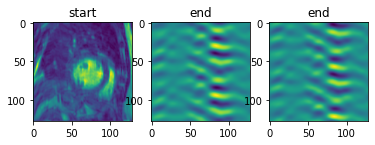

In [127]:
import matplotlib.pyplot as plt

plotframe = 6
f,ax = plt.subplots(1,3)
ax[0].imshow(np.flip(np.abs(np.squeeze(u_k[:,:,plotframe])),axis=0))
ax[0].set_title('start')
ax[1].imshow(np.flip(np.real(np.squeeze(result[:,:,plotframe])),axis=0))
ax[1].set_title('end')
ax[2].imshow(np.flip(np.imag(np.squeeze(result[:,:,plotframe])),axis=0))
ax[2].set_title('end')

Text(0.5, 1.0, 'end')

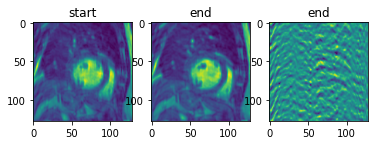

In [80]:
import nibabel as nib
nii = nib.Nifti1Image(np.abs(result),np.eye(4))
nib.save(nii,"{0}/result_mi{1}.nii".format(DIR,maxiter))
import matplotlib.pyplot as plt

plotframe = 6
f,ax = plt.subplots(1,3)
ax[0].imshow(np.flip(np.abs(np.squeeze(u_k[:,:,plotframe])),axis=0))
ax[0].set_title('start')
ax[1].imshow(np.flip(np.real(np.squeeze(result[:,:,plotframe])),axis=0))
ax[1].set_title('end')
ax[2].imshow(np.flip(np.imag(np.squeeze(result[:,:,plotframe])),axis=0))
ax[2].set_title('end')

In [ ]:
y.imag